##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF Hub for TF2: Image Module Retraining (preview)

<table align="left">
<td align="center">
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /><br>Run in Google Colab
  </a>
</td>
<td align="center">
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /><br>View source on GitHub</a>
</td>
</table>

This Colab demonstrates the use of TF2 SavedModels found on TensorFlow Hub with Keras. It uses a pre-trained image feature vector module for classifying five species of flowers, including fine-tuning of the module.

## Set up TensorFlow 2 and other libraries

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import itertools
import os
import re
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pathlib

import pandas as pd


print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


TF version: 2.0.0
Hub version: 0.6.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'Dataset',
#     'gs://labidub/Dataset.tar.gz',
    'https://console.cloud.google.com/storage/browser/labidub/Dataset.tar.gz',
    untar=True)

In [4]:
!gsutil cp gs://labidub/Dataset_Fill.tar.gz .
!tar xzf Dataset_Fill.tar.gz

Copying gs://labidub/Dataset_Fill.tar.gz...
| [1 files][  4.2 GiB/  4.2 GiB]   82.4 MiB/s                                   
Operation completed over 1 objects/4.2 GiB.                                      


In [5]:
!gsutil cp gs://labidub/Dataset.tar.gz .

In [28]:
!tar xzf Dataset.tar.gz

In [4]:
pwd

'/home/jupyter/labidub/unimodal-image/hub/examples/colab'

In [6]:
data_dir = pathlib.Path('./Dataset')
data_dir=str(data_dir)

In [52]:
data_dir = pathlib.Path('./Dataset_Fill')
data_dir=str(data_dir)

In [7]:
# ls  . | sed -e 's/\(.*\)/train\/\1/g' | xargs mkdir -p 
# ls  . | sed -e 's/\(.*\)/test\/\1/g' | xargs mkdir -p 

In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear",seed=9001)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

Found 25199 images belonging to 2 classes.


In [6]:
train_generator = test_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, **dataflow_kwargs)

Found 100801 images belonging to 2 classes.


In [7]:
data_dir

'Dataset_Fill'

In [54]:
data_dir = "Dataset_Fill/train"
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
    train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 20148 images belonging to 51 classes.
Found 80656 images belonging to 51 classes.



## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [56]:
do_fine_tuning = True #@param {type:"boolean"}

In [57]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  21802784  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  104499    
Total params: 21,907,283
Trainable params: 21,872,851
Non-trainable params: 34,432
_________________________________________________________________


## Training the model

In [58]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [59]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [ ]:
hist = model.fit_generator(
    train_generator,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,verbose=1).history

Epoch 1/3
2520/2520 [==============================] - 2198s 872ms/step - loss: 1.4291 - accuracy: 0.8299 - val_loss: 2.6958 - val_accuracy: 0.5004
Epoch 2/3
1691/2520 [===================>..........] - ETA: 11:24 - loss: 1.3987 - accuracy: 0.8395

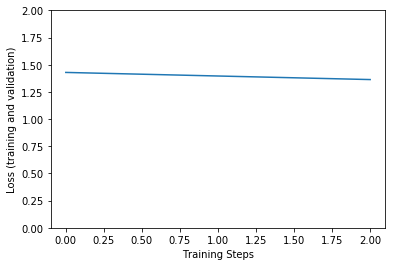

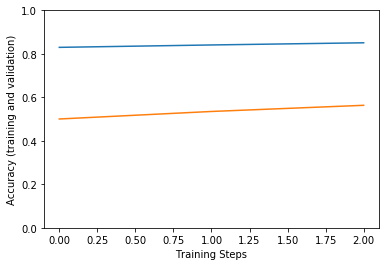

In [41]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [38]:
hist

{'accuracy': [0.82985216, 0.84089106, 0.8508385],
 'loss': [1.4290987213208197, 1.3962311056261618, 1.3634767802042203],
 'val_accuracy': [0.50039744, 0.53502584, 0.5633446],
 'val_loss': [2.695763185501857, 2.6466522813790934, 2.444194936695463]}

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [42]:
saved_model_path = "./saved_lip_fill"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


INFO:tensorflow:Assets written to: ./saved_lip_fill/assets


In [ ]:
pred

In [ ]:
# model.evaluate_generator(generator=valid_generator,
# steps=STEP_SIZE_VALID)

# STEP_SIZE_TEST=valid_generator.n//valid_generator.batch_size
# valid_generator.reset()
# pred=model.predict_generator(valid_generator,
# steps=STEP_SIZE_TEST,
# verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]


filenames = valid_generator.filenames
nb_samples = len(filenames)

# # filenames = test_generator.filenames
# # nb_samples = len(filenames)

predict = model.predict_generator(valid_generator,steps = nb_samples,
verbose=1)
predicted_class_indices=np.argmax(predict,axis=1)

# model.predict_generator()

 5935/25196 [======>.......................] - ETA: 1:00:28

In [27]:
len(test_generator.filenames)

25199

In [13]:
test_dir = 'Dataset_Fill/test'
# !ls

testgen_kwargs = dict(rescale=1./255, validation_split=.20)
testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    **testgen_kwargs)

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)

TEST_BATCH_SIZE = len(test_generator.filenames)

testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)


Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.


In [21]:

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples/BATCH_SIZE, verbose=True)

# filenames = valid_generator.filenames
# nb_samples = len(filenames)
# predict = model.predict_generator(valid_generator,steps = nb_samples,
# verbose=1)
# predicted_class_indices=np.argmax(predict,axis=1)

# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]

# filenames=valid_generator.filenames
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions":predictions})
# results.to_csv("results.csv",index=False)

788/787 [==============================] - 210s 267ms/step


In [216]:
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_generator.class_indices)

In [26]:
labels = dict((v,k) for k,v in labels.items())

In [216]:
# predictions = [labels[k] for k in predicted_class_indices]
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions":predictions})
# results.to_csv("results.csv",index=False)
# label_df = pd.DataFrame.from_dict(labels, orient='index',columns=['str_label'])
# label_df.index.name='index'
labels[51]='Missing'  
def word_to_int(str_label):
    try:
        return int(label_df[label_df['str_label']==str_label].index.values[0])
    except:
        return None

In [197]:
predictions = [labels.get(k) for k in predicted_class_indices]
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_pred.csv",index=False)


In [217]:
results['label'] = results.apply(lambda x: x['Filename'].split('_')[2].split('.')[0], axis=1)
results['n_label'] = results.apply(lambda x: word_to_int(x['label']), axis=1)
results[results['Predictions'].isna()] = 'Missing'


In [199]:
results['n_prediction'] = predicted_class_indices

In [254]:
results[results['n_label'].isnull()]['Filename']

Series([], Name: Filename, dtype: object)

In [253]:
results = results.drop(results.index[1218])

In [16]:
# results.to_csv(""results_pred2".csv",index=False)
results = pd.read_csv("results_pred2.csv")

In [18]:
results

,Filename,Predictions,label,n_label,n_prediction
0,a/s10_lbaa2n_a.jpg,e,a,0.0,9
1,a/s10_lbaa3s_a.jpg,l,a,0.0,21
2,a/s10_lbaa4p_a.jpg,e,a,0.0,9
3,a/s10_lbaa5a_a.jpg,white,a,0.0,45
4,a/s10_lbba6n_a.jpg,j,a,0.0,19
...,...,...,...,...,...
25191,zero/s16_briezs_zero.jpg,Missing,zero,50.0,51
25192,zero/s16_brirza_zero.jpg,Missing,zero,50.0,51
25193,zero/s16_brwszs_zero.jpg,soon,zero,50.0,39
25194,zero/s16_bwafzs_zero.jpg,Missing,zero,50.0,51


In [89]:
new_list = [str(labels.get(k)) for k in predicted_class_indices]


In [73]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report,mean_squared_error
import seaborn as sns; sns.set()


In [138]:
  

# label_df = pd.DataFrame.from_dict(labels, orient='index',columns=['str_label'])
# label_df.index.name='index'
# word_to_int = dict((c,i) for i,c in enumerate(word_map))
#     #print(word_to_int)
#     int_to_word = dict((i,c) for i,c in enumerate(word_map))
#     #print(target[1])
#     #print(word_to_int[target[1]])
#     interger_encoded = [word_to_int[word] for word in label]
    
#     onehot_encoded = list()
#     for value in interger_encoded:
#         letter = [0 for _ in range(len(word_map))]
#         letter[value] = 1
#         onehot_encoded.append(letter)
#     result = np.asarray(onehot_encoded,dtype = np.int32)

In [208]:
# predicted_class_indices
results.n_label
# word_map = ['bin','lay','place','set',
#            'blue','red','green','white',
#            'at','in','with','by',
#            'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','x','y','z',
#            'zero','one','two','three','four','five','six','seven','eight','nine',
#            'again','now','soon','please']
# word_to_int = dict((c,i) for i,c in enumerate(word_map))
# #print(word_to_int)
# int_to_word = dict((i,c) for i,c in enumerate(word_map))
# #print(target[1])
# #print(word_to_int[target[1]])
# interger_encoded = [word_to_int[word] for word in label]

0         0
1         0
2         0
3         0
4         0
         ..
25192    50
25193    50
25194    50
25195    50
25196    50
Name: n_label, Length: 25197, dtype: object

In [24]:
# from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import classification_report
# con_mat = tf.math.confusion_matrix(
#     labels=results.n_label,
#     predictions=results.n_prediction)
    
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.string,
#     name=None
# )
# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
# con_mat_df = pd.DataFrame(con_mat_norm,
#                      index = classes, 
#                      columns = classes)
conf_matrix = confusion_matrix(y_true=results.n_label, y_pred=results.n_prediction)
print('\nClassification Report:\n', classification_report(y_true=results.n_label, y_pred=results.n_prediction, labels=))
# x_axis_labels = ['GB','US'] # labels for x-axis
# y_axis_labels = ['GB','US'] # labels for y-axis

# ax = sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="YlGnBu")
#                  , 
#                  xticklabels=x_axis_labels, yticklabels=y_axis_labels)


Classification Report:
              precision    recall  f1-score   support

        0.0       0.45      0.24      0.31       168
        1.0       0.88      0.65      0.75      1050
        2.0       0.50      0.29      0.36      1049
        3.0       0.55      0.25      0.34       168
        4.0       0.76      0.72      0.74      1056
        5.0       0.44      0.92      0.60      1050
        6.0       0.76      0.75      0.76      1048
        7.0       0.22      0.04      0.06       168
        8.0       0.17      0.01      0.01       168
        9.0       0.21      0.11      0.15       168
       10.0       0.26      0.16      0.20       420
       11.0       0.82      0.52      0.64       168
       12.0       0.88      0.61      0.72       420
       13.0       0.58      0.90      0.70       420
       14.0       0.16      0.32      0.21       168
       15.0       0.42      0.53      0.47      1050
       16.0       0.34      0.60      0.44       168
       17.0       0.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [41]:
conf_matrix = confusion_matrix(y_true=results.label, y_pred=results.Predictions)
print('\nClassification Report:\n', classification_report(y_true=results.label, y_pred=results.Predictions))



Classification Report:
              precision    recall  f1-score   support

    Missing       0.00      0.00      0.00         0
          a       0.45      0.24      0.31       168
      again       0.88      0.65      0.75      1050
         at       0.50      0.29      0.36      1049
          b       0.55      0.25      0.34       168
        bin       0.76      0.72      0.74      1056
       blue       0.44      0.92      0.60      1050
         by       0.76      0.75      0.76      1048
          c       0.22      0.04      0.06       168
          d       0.17      0.01      0.01       168
          e       0.21      0.11      0.15       168
      eight       0.26      0.16      0.20       420
          f       0.82      0.52      0.64       168
       five       0.88      0.61      0.72       420
       four       0.58      0.90      0.70       420
          g       0.16      0.32      0.21       168
      green       0.42      0.53      0.47      1050
          h       0.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
import seaborn as sns

In [40]:
results.Predictions.unique()

array(['e', 'l', 'white', 'j', 'a', 'x', 'two', 'at', 'one', 'v', 'again',
       'now', 'by', 'r', 'in', 'eight', 'bin', 'nine', 's', 'm', 'green',
       'five', 'o', 't', 'n', 'soon', 'blue', 'four', 'd', 'g', 'three',
       'with', 'p', 'u', 'Missing', 'h', 'q', 'seven', 'please', 'y',
       'set', 'lay', 'red', 'b', 'place', 'c', 'zero', 'six', 'f', 'k',
       'z'], dtype=object)

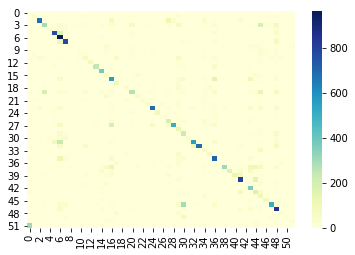

In [44]:
ax = sns.heatmap(conf_matrix,annot=False,fmt="d",cmap="YlGnBu"
                 , xticklabels='auto', yticklabels='auto')
#                  xticklabels=x_axis_labels, yticklabels=y_axis_labels)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


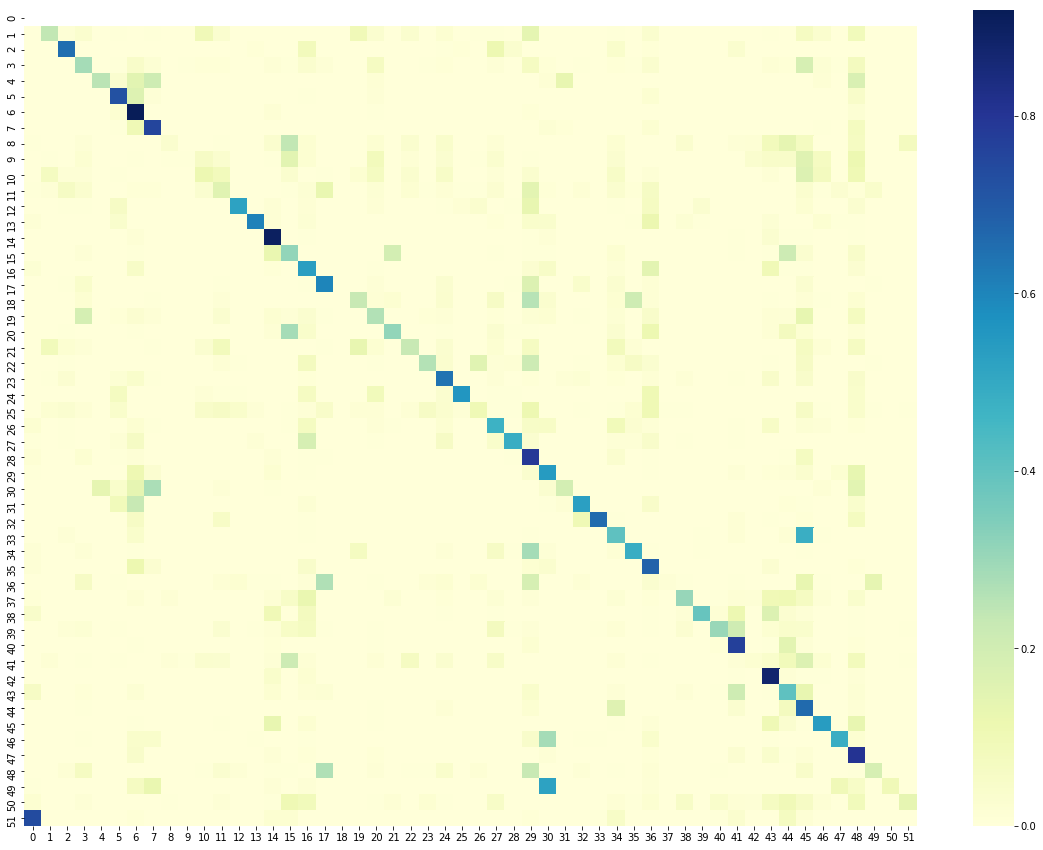

In [49]:
plt.subplots(figsize=(20,15))

cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm,annot=False,fmt="d",cmap="YlGnBu",annot_kws={"size": 16})


In [25]:
labels

NameError: name 'labels' is not defined

In [46]:
filenames = valid_generator.filenames
nb_samples = len(filenames)
nb_samples

20148

In [49]:
len(predictions)


644364

## Load Saved Model

In [14]:
saved_model_path = "./saved_lip_fill"

In [50]:
model = tf.keras.models.load_model(saved_model_path)

# model = tf.saved_model.load(
#     export_dir=saved_model_path,
#     tags=None
# )

# model, saved_model_path

# Further Training 


In [ ]:
hist = model.fit_generator(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,verbose=1).history

Epoch 1/10
2520/2520 [==============================] - 5016s 2s/step - loss: 2.2461 - accuracy: 0.4015 - val_loss: 3.5477 - val_accuracy: 0.3107
Epoch 2/10
2520/2520 [==============================] - 3259s 1s/step - loss: 1.6745 - accuracy: 0.7347 - val_loss: 2.6874 - val_accuracy: 0.4839
Epoch 3/10
2520/2520 [==============================] - 3261s 1s/step - loss: 1.5492 - accuracy: 0.7867 - val_loss: 2.4580 - val_accuracy: 0.5382
Epoch 4/10
2520/2520 [==============================] - 3251s 1s/step - loss: 1.4772 - accuracy: 0.8085 - val_loss: 2.3708 - val_accuracy: 0.5622
Epoch 5/10
2520/2520 [==============================] - 3246s 1s/step - loss: 1.4238 - accuracy: 0.8309 - val_loss: 2.3962 - val_accuracy: 0.5502
Epoch 6/10
2520/2520 [==============================] - 3239s 1s/step - loss: 1.3867 - accuracy: 0.8424 - val_loss: 2.7840 - val_accuracy: 0.4676
Epoch 7/10
2520/2520 [==============================] - 3253s 1s/step - loss: 1.3584 - accuracy: 0.8544 - val_loss: 2.6432 -

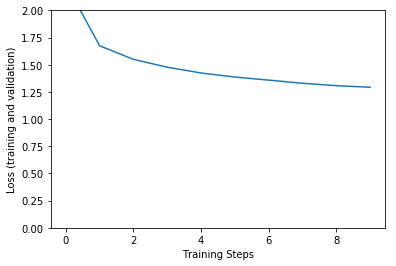

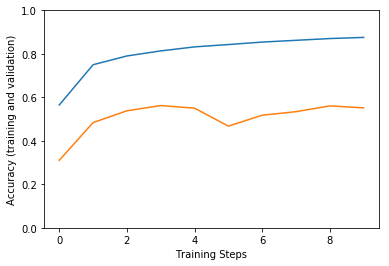

In [64]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [67]:
model

TypeError: 'History' object is not callable

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [ ]:
saved_model_path = "./saved_lip_fill_retrain"
tf.saved_model.save(model, saved_model_path)

In [69]:
test_dir = 'Dataset_Fill/test'
# !ls

testgen_kwargs = dict(rescale=1./255, validation_split=.20)
testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    **testgen_kwargs)

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)

TEST_BATCH_SIZE = len(test_generator.filenames)

testflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

test_generator = test_gen.flow_from_directory(
    test_dir, subset=None, shuffle=False, **testflow_kwargs)


Found 25196 images belonging to 51 classes.
Found 25196 images belonging to 51 classes.


In [73]:

filenames = test_generator.filenames
nb_samples = len(filenames)
predict = model.predict_generator(test_generator,steps = nb_samples/BATCH_SIZE, verbose=True)

predicted_class_indices=np.argmax(predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [75]:
predictions = [labels.get(k) for k in predicted_class_indices]

results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results['label'] = results.apply(lambda x: x['Filename'].split('_')[2].split('.')[0], axis=1)
results.to_csv("results_pred_retrain.csv",index=False)

# model.evaluate_generator(generator=test_generator,steps = nb_samples/BATCH_SIZE, verbose=True

In [76]:
conf_matrix = confusion_matrix(y_true=results.label, y_pred=results.Predictions)
print('\nClassification Report:\n', classification_report(y_true=results.label, y_pred=results.Predictions))



Classification Report:
              precision    recall  f1-score   support

          a       0.25      0.52      0.34       168
      again       0.76      0.87      0.81      1050
         at       0.56      0.26      0.35      1049
          b       0.35      0.20      0.26       168
        bin       0.63      0.76      0.69      1056
       blue       0.62      0.70      0.66      1050
         by       0.63      0.85      0.73      1048
          c       0.28      0.15      0.19       168
          d       0.36      0.03      0.05       168
          e       0.36      0.11      0.17       168
      eight       0.20      0.29      0.24       420
          f       0.62      0.70      0.66       168
       five       0.79      0.74      0.76       420
       four       0.19      0.93      0.31       420
          g       0.41      0.37      0.39       168
      green       0.75      0.22      0.33      1050
          h       0.60      0.27      0.37       168
          i       0.

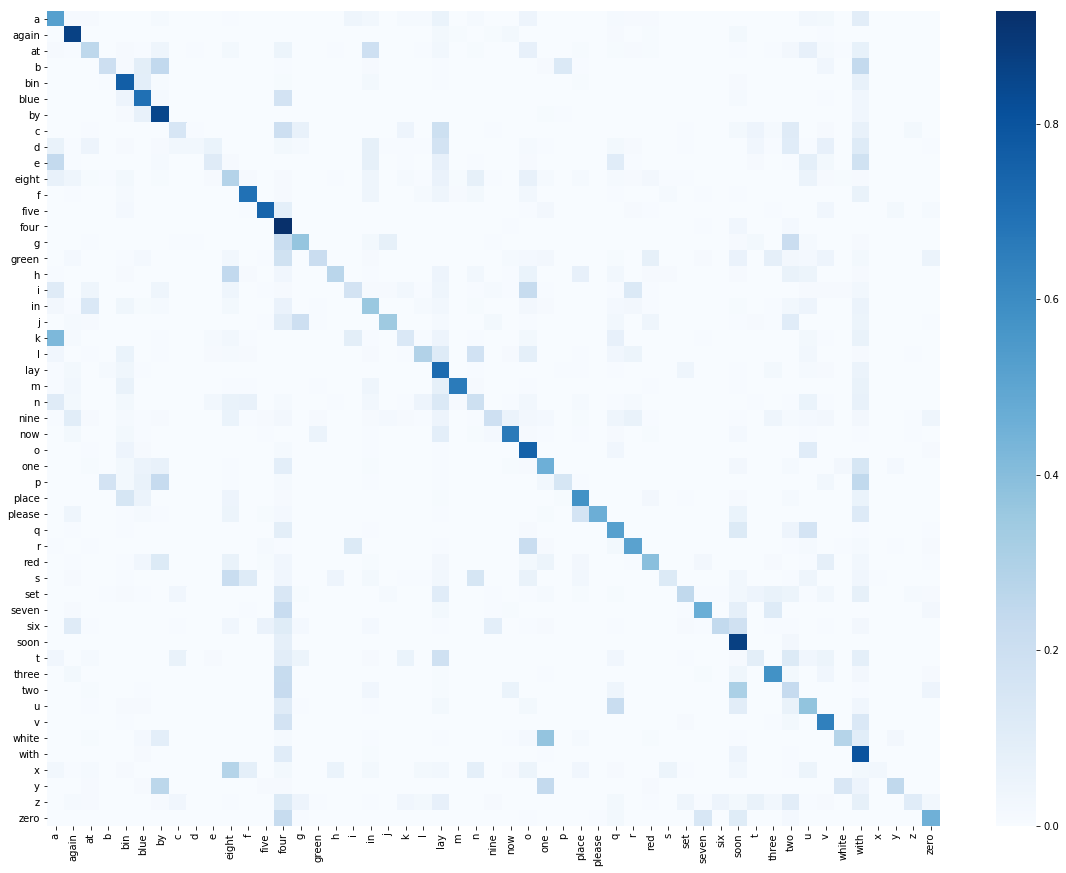

In [97]:
import seaborn as sns
plt.subplots(figsize=(20,15))

cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm,annot=False,fmt="d",cmap=plt.cm.Blues,annot_kws={"size": 16},
                xticklabels=results.label.unique(),yticklabels=results.label.unique())

In [98]:

results_reindex = results.label.str.len().sort_values().index

In [99]:
results_new = results.reindex(results_reindex)
results_new = results_new.reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

          a       0.25      0.52      0.34       168
      again       0.76      0.87      0.81      1050
         at       0.56      0.26      0.35      1049
          b       0.35      0.20      0.26       168
        bin       0.63      0.76      0.69      1056
       blue       0.62      0.70      0.66      1050
         by       0.63      0.85      0.73      1048
          c       0.28      0.15      0.19       168
          d       0.36      0.03      0.05       168
          e       0.36      0.11      0.17       168
      eight       0.20      0.29      0.24       420
          f       0.62      0.70      0.66       168
       five       0.79      0.74      0.76       420
       four       0.19      0.93      0.31       420
          g       0.41      0.37      0.39       168
      green       0.75      0.22      0.33      1050
          h       0.60      0.27      0.37       168
          i       0.

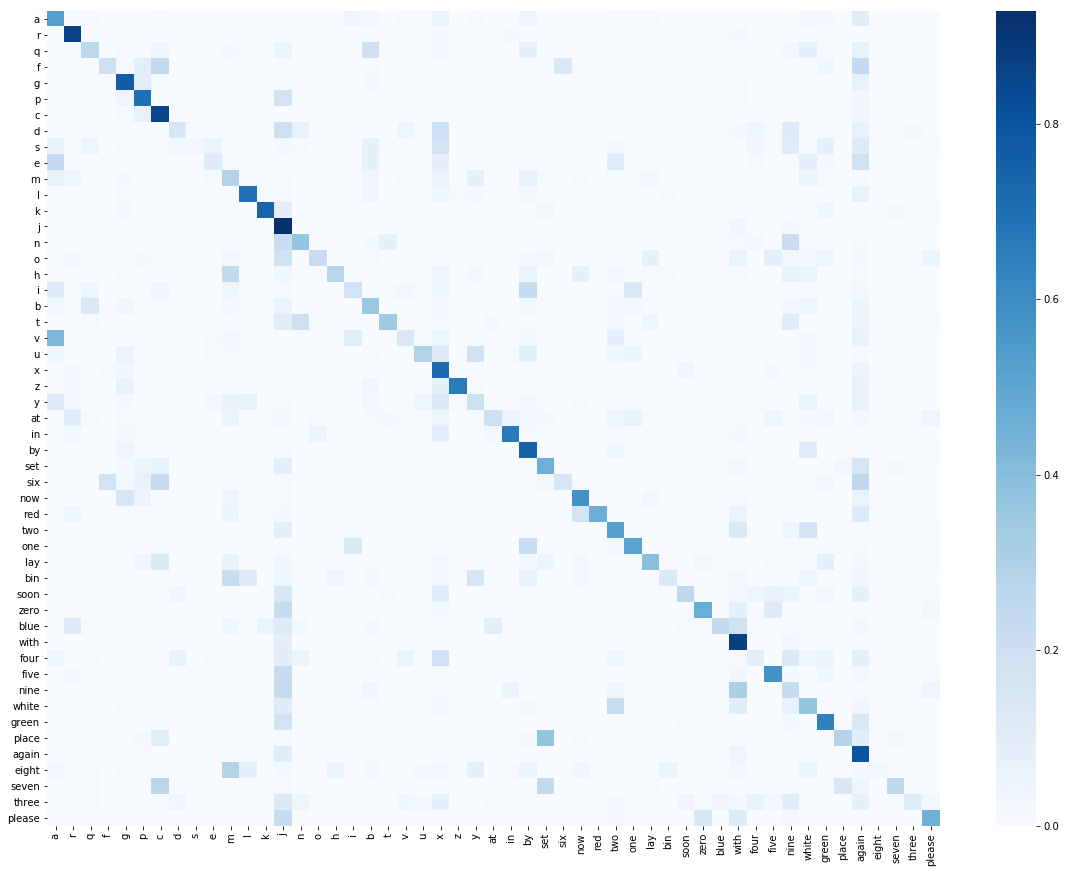

In [101]:
conf_matrix = confusion_matrix(y_true=results_new.label, y_pred=results_new.Predictions)
print('\nClassification Report:\n', classification_report(y_true=results_new.label, y_pred=results_new.Predictions))

plt.subplots(figsize=(20,15))
cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cm,annot=False,fmt="d",cmap=plt.cm.Blues,annot_kws={"size": 16},
                xticklabels=results_new.label.unique(),yticklabels=results_new.label.unique())

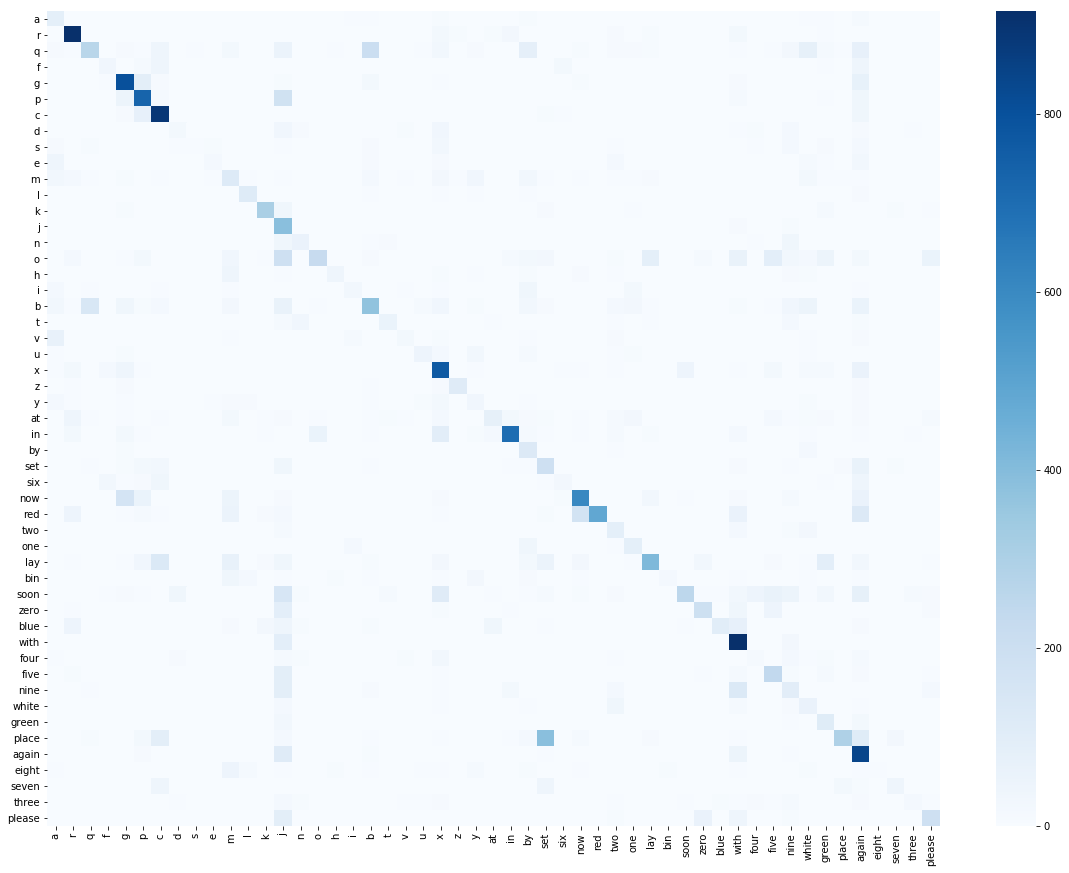

In [103]:
plt.subplots(figsize=(20,15))

ax = sns.heatmap(conf_matrix,annot=False,fmt="d",cmap=plt.cm.Blues,annot_kws={"size": 16},
                xticklabels=results_new.label.unique(),yticklabels=results_new.label.unique())